In [11]:
import random

WORDS_FILE = 'russian_surnames.txt'
words = open(WORDS_FILE, 'r', encoding="utf8").read().splitlines()
random.seed(244)
random.shuffle(words)
if len(words) > 100000:
    words = words[:100000]
words = [w.lower() for w in words]
words = [w for w in words if (len(w) > 0)]
words[:10]
letters = sorted(list(set(''.join(words))))
chtoi = {ch:(i+1) for i,ch in enumerate(letters)}
chtoi['.'] = 0
itoch = {i:ch for ch,i in chtoi.items()}
N = len(letters) + 1

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

CTX_SZ = 8

def make_dataset(words):
    x, y = [], []
    for w in words:        
        ctx = [0] * CTX_SZ
        for ch in w + '.':
            idx = chtoi[ch]
            x.append(ctx)
            y.append(idx)
            ctx = ctx[1:] + [idx]
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_trn, y_trn = make_dataset(words[:n1])
x_dev, y_dev = make_dataset(words[n1:n2])
x_tst, y_tst = make_dataset(words[n2:])

N_SAMPLES_TRN = x_trn.shape[0]
N_SAMPLES_DEV = x_dev.shape[0]
N_SAMPLES_TST = x_tst.shape[0]

In [13]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.randn(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        # buffers
        self.running_var  = torch.ones(dim)
        self.running_mean = torch.zeros(dim)
    def __call__(self, x):
        if self.training:
            dims = 0 if x.ndim == 2 else (0,1)
            xmean = x.mean(dims, keepdim=True) # batch mean
            xvar  = x.var(dims, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar  = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, n, dim):
        self.table = torch.randn((n, dim))
    def __call__(self, IX):
        self.out = self.table[IX]
        return self.out
    def parameters(self):
        return [self.table]
        
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [14]:
HID_SZ = 128
EMB_DIM = 32

model = Sequential([
    Embedding(N, EMB_DIM),
    FlattenConsecutive(2), Linear(EMB_DIM * 2, HID_SZ, bias=False), BatchNorm1d(HID_SZ), Tanh(),
    FlattenConsecutive(2), Linear(HID_SZ * 2, HID_SZ, bias=False), BatchNorm1d(HID_SZ), Tanh(),
    FlattenConsecutive(2), Linear(HID_SZ * 2, HID_SZ, bias=False), BatchNorm1d(HID_SZ), Tanh(),
    Linear(HID_SZ, N)
])
with torch.no_grad():
    model.layers[-1].weights *= 0.1 # less confident init

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

In [15]:
ITS = 200000
BATCH_SZ = 32

LR = 0.1
losses = []

def eval_loss(x, y, batch):
    logits = model(x if batch is None else x[batch])
    loss = F.cross_entropy(logits, y if batch is None else y[batch])
    return loss

In [16]:
for l in model.layers:
    l.training = True

for i in range(ITS):
    bix = torch.randint(0, N_SAMPLES_TRN, (BATCH_SZ,))
    loss = eval_loss(x_trn, y_trn, bix)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = (LR/10) if (i > 3 * ITS / 4) else LR
    for p in parameters:
        p.data -= lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{ITS:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())

for l in model.layers:
    l.training = False

      0/ 200000: 4.4473
  10000/ 200000: 1.9222
  20000/ 200000: 1.7394
  30000/ 200000: 1.9434
  40000/ 200000: 2.0690
  50000/ 200000: 2.2627
  60000/ 200000: 2.6607
  70000/ 200000: 1.6879
  80000/ 200000: 1.9788
  90000/ 200000: 1.8350
 100000/ 200000: 1.6128
 110000/ 200000: 2.0322
 120000/ 200000: 2.1701
 130000/ 200000: 2.7104
 140000/ 200000: 2.2600
 150000/ 200000: 2.2252
 160000/ 200000: 1.7779
 170000/ 200000: 1.6523
 180000/ 200000: 1.4938
 190000/ 200000: 2.0905


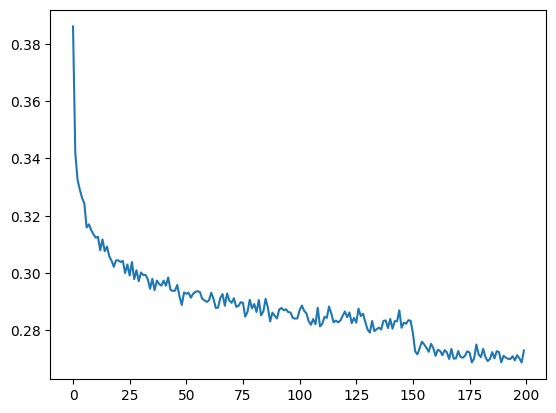

In [17]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

In [18]:
print(eval_loss(x_trn, y_trn, None).item())
print(eval_loss(x_dev, y_dev, None).item())

1.8626943826675415
1.904051661491394


In [19]:
g = torch.Generator().manual_seed(2147483647)
idx = 0
for k in range(100):
    word = ''
    ctx = [0] * CTX_SZ
    while True:
        logits = model(torch.tensor([ctx]))
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ctx = ctx[1:] + [idx]
        if idx == 0:
            print(word)
            break
        word += itoch[idx]

кухивицкому
звиодневой
баладина
ктнянисом
галабком
вучиловскому
вавузкове
терсмирем-чукова
дерлулис
довтулиной
макирину
шпарник
чернянова
ставинский
залячкиной
босмалина
сосоницкене
лотовым
шерихиной
котярчинску
зенгалы
халавуллая
фурхина
блиберовым
вожидском
добрунский
жураповым
неаштаева
копыркина
светковым
пыновесткине
фарусовым
кадамиловой
грибухи
урдину
звовощникове
осреблиным
хомыке
фельдгефером
шенавскую
велькин
самашниковым
кидюгина
кихарбашева
берелиной
артмана
сивницкий
савяничу
хиспвой
фивнова
ситухатиным
савостиковым
комадуловой
осикалин
навлакову
любашкина
ливчаеву
метниновском
базнушкине
енифанову
тарадзедокине
крикуне
митрашов
заселем
грозове
геничем
маралиуковой
белтовичу
костаркинский
гаршину
иззюховой
шалажев
солаконица
фламове
белюшевым
гранкеле
волобуда
кронушиченко
поруновым
пенфельтом
тырбаевым
комшеве
митланчук
силитовых
саводькиной
тимоине
шуледаеве
комичевкину
чус
воложенбергу
настоянского
шаруфиловой
хлопичеве
вычьян
зимоферов
пижукави
бахаду
похалюком
голущ
о